On the command line in Savio, please activate the conda environment and install the allpredictors kernel as follows. This only needs to be done the very first time you use the notebook.

`ml python/3.7; source activate /global/scratch/projects/fc_mvslab/conda/allpredictors`

`python -m ipykernel install --user --name=allpredictors`

Looking at the ribbon above, please click Kernel >> Change kernel >> allpredictors.

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Load necessary modules
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['font.sans-serif'] = 'Arial'
from matplotlib import pyplot as plt
import matplotlib.backends.backend_pdf
import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")
from Bio import SeqIO
import glob, pickle, os, re, subprocess, csv, sys
from uuid import uuid4
import ipyparallel as ipp

In [7]:
import os
os.chdir("../../../../../predictors/all_predictors/")

In [8]:
sys.path.append(os.path.abspath('..'))
from PADDLE import paddle
from iupred3.iupred import get_iupred
from adpred import ADpred as adp
from TADA.src.Preprocessing import scale_features
from TADA.src.Preprocessing import create_features
from TADA.src.Predict_model_only import tada_predict

import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn import preprocessing
from pickle import dump
import pytorch_lightning as pl
from actpred.models import ActCNNSystem
from actpred.utils import get_threshold, get_stratified_split

from scipy.stats import spearmanr
# from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
# from pytorch_lightning.loggers import CSVLogger, WandbLogger

# Set Numpy to display floats with 3 decimal places
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})



    
If you wish to use a local installation of psipred, please indicate this,
    by assigning the path to local_psipred (e.g. local_psipred = "~/psipred/run_psipred")


2025-05-16 11:45:19.450575: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/global/home/users/sanjanakotha/.conda/envs/sk_allpredictors/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


### To run the predictors on many sequences, please see the BATCH section below the first STOP
### To run the predictor on a single sequence, please run all cells until you see the first STOP

<br>

Please delete/move files in tmp_output after you're done. Files in tmp_output should not be expected to stay there permanently.

In [10]:
# Provide the path to a fasta file containing your sequences

# INPUT PATH TO FASTA FILE HERE
fasta_name = '/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/consensus_AD_predictor/data/yeast_TFs.fasta'

tmp_output = '/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/consensus_AD_predictor/output/yeast_TFs_preds/tada'

# BATCH mode begins here

Please delete/move files in tmp_output after you're done. Files in tmp_output should not be expected to stay there permanently.

In [11]:
ipp.__version__   # check that at least version 7
mycluster = ipp.Cluster(n = int(os.getenv('SLURM_CPUS_ON_NODE')))
mycluster.start_cluster_sync()

c = mycluster.connect_client_sync()
c.wait_for_engines(n = int(os.getenv('SLURM_CPUS_ON_NODE')))
c.ids

Starting 32 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>
100%|██████████| 32/32 [00:08<00:00,  3.72engine/s]


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31]

In [12]:
dview = c[:]
dview.block = True

# Load necessary modules on workers
dview.execute('import sys, os')
dview.execute('sys.path.append(os.path.abspath(".."))')
dview.execute('import pandas as pd')
dview.execute('import numpy as np')
dview.execute('import re, subprocess')
dview.execute('import Bio')
dview.execute('from PADDLE import paddle')
dview.execute('from adpred import ADpred as adp')
dview.execute('import torch')
dview.execute('from TADA.src.Preprocessing import scale_features')
dview.execute('from TADA.src.Preprocessing import create_features')
dview.execute('from TADA.src.Predict_model_only import tada_predict')
dview.execute('from TADA.src.Predict_model_only import load_model')

<AsyncResult(execute): finished>

In [13]:
# for i in range(len(recs)):
#     print(len(str(recs[i].seq)))

In [14]:
aa_lst = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

# Set up directories for storing output, including PSIPRED and IUPred predictions
fasta_name_tmp = fasta_name.split('/')[-1].strip('.fasta').strip('.fa')
output_dir = tmp_output + '/' + fasta_name_tmp
subprocess.run(['mkdir', output_dir])
recs = list(SeqIO.parse(fasta_name, 'fasta'))
fasta_name = fasta_name_tmp
for r in recs:
    sequence = str(r.seq)
    assert len(sequence) >= 53, 'Protein sequence must be at least 53 amino acids long' 
    assert len(set(sequence) - set(aa_lst)) == 0, 'No non-standard amino acids allowed'
    sub_fasta_name = re.sub(r'\s+', '_', r.id)
    subprocess.run(['mkdir', output_dir + '/' + sub_fasta_name])
    with open(output_dir + '/' + sub_fasta_name + '/' + sub_fasta_name + '.fasta', 'w') as fa:
        fa.write(sequence)

# PSIPRED

Both PADDLE and ADpred need secondary structure predictions from PSIPRED. 

In [42]:
# path to a local installation of psipred
local_psipred = '/global/scratch/projects/fc_mvslab/predictors/psipred/runpsipred'


def adpred_read_ss2(ss2):
    '''
    Converts .ss2 data to horizontal secondary structure information (e.g., --HHHHH--HHHHH-HH)
    
    ss2: name of .ss2 file
    '''
    df = pd.read_table(ss2, skiprows=[0], sep='\s+', names=['position', 'residue', 'ss', 'c', 'h', 'e'])
    return ''.join(df.ss.values).replace('C','-')

def get_psipred(seq, output_dir=output_dir, fasta_name=fasta_name, computed=None):
    '''
    Runs PSIPRED on the provided sequence and returns secondary structure
    data for PADDLE and ADpred, viz
    (paddle_seq, paddle_helix, paddle_coil), 'adpred_ss_as_a_string'
    
    seq: provided sequence
    output_dir: path to output directory containing fasta file
    fasta_name: name of fasta file, minus the .fasta/.fa file ending
    computed: path to already computed .ss2 file to skip re-running PSIPRED
    ''' 
    if computed is not None:
        return paddle.read_ss2(computed), adpred_read_ss2(computed)
    
    p = subprocess.run('cd "{}" && {} "{}".fa*'.format(output_dir, local_psipred, fasta_name), 
                       capture_output=True, shell=True, encoding='utf-8')
    rootname = re.search('Final output files: (.*).ss2 (.*).horiz', p.stdout).group(1).strip()
    
    paddle_ss = paddle.read_ss2(output_dir + '/' + rootname + '.ss2')
    f = open(output_dir + '/' + rootname + '.horiz')
    adpred_ss = ''.join([i.group(1) for i in re.finditer('Pred: (.*)\n', ''.join(f))]).replace("C","-")

    return paddle_ss, adpred_ss

In [43]:
%%time

dview = c[:]
dview.block = True

# Push variables and functions to workers
var = dict( output_dir=output_dir, local_psipred=local_psipred, fasta_name=fasta_name, adpred_read_ss2=adpred_read_ss2, get_psipred=get_psipred )
dview.push(var)

# Need a wrapper function because map() only operates on one argument
def wrapper(r):
    sequence = str(r.seq)
    sub_fasta_name = re.sub(r'\s+', '_', r.id)
    paddle_ss, adpred_ss = get_psipred(sequence, output_dir=output_dir + '/' + sub_fasta_name, fasta_name=sub_fasta_name,)
                                      #computed="{}/{}/{}.ss2".format(output_dir, sub_fasta_name, sub_fasta_name) )
    assert paddle_ss[0] == sequence
    return (sequence, [paddle_ss, adpred_ss])

# Run a parallel map, executing the wrapper function on indices 0,...,n-1
lview = c.load_balanced_view()
# Cause execution on main process to wait while tasks sent to workers finish
lview.block = True 
out = lview.map(wrapper, recs)   # Run calculation in parallel
ss_dict = dict(out)

CPU times: user 187 ms, sys: 99.8 ms, total: 287 ms
Wall time: 39.9 s


# PADDLE

PADDLE needs disorder predictions from IUPred. 

In [44]:
def read_iupred_batch(recs, output_dir=output_dir, fasta_name=fasta_name, computed_long=None, computed_short=None):
    '''
    Runs IUPred on the provided sequences and returns two dictionaries:
    {sequences: lists of long-style predicted disorder values} and
    {sequences: lists of short-style predicted disorder values}
    
    recs: list of Bio.SeqRecord objects containing the provided sequences
    output_dir: path to output directory
    fasta_name: path to fasta file
    computed_long: path to already computed long-style .dis file to skip re-running IUPred
    computed_short: path to already computed short-style .dis file to skip re-running IUPred
    ''' 
    if computed_long is not None and computed_short is not None:
        return read_iupred_dict(computed_long), read_iupred_dict(computed_short)
    
    with open(output_dir + '/' + fasta_name + '_long.dis', 'w') as dis:
        for r in recs:
            dis.write('> ' + r.id + '\n')
            dis.write(get_iupred(str(r.seq), iupred_type='long'))
            dis.write('\n\n')
    with open(output_dir + '/' + fasta_name + '_short.dis', 'w') as dis:
        for r in recs:
            dis.write('> ' + r.id + '\n')
            dis.write(get_iupred(str(r.seq), iupred_type='short'))
            dis.write('\n\n')
    
    long_out = read_iupred_dict(output_dir + '/' + fasta_name + '_long.dis')
    short_out = read_iupred_dict(output_dir + '/' + fasta_name + '_short.dis')
    
    return long_out, short_out


def read_iupred_dict(file):
    """
    Read disorder predictions produced by IUPRED2 from the .dis file
    Adapted from PADDLE's native read_iupred fn due to formatting
    Inputs:
        - file: Filename of the .dis file output by IUPRED2
    Returns:
        - iupred_dict: Dictionary of prot keys and dis values
        where
        - prot: Protein sequence (string)
        - dis:  List of predicted disorder (values between 0 and 1)
    """

    f = open(file, 'r')
    iupred_dict = dict()
    dis = []
    prot = ''

    for line in f:
        line = line.strip()
        if line.startswith('>'):
            iupred_dict[prot] = dis
            dis = []
            prot = ''
            continue
        if '#' in line or line == "":
            continue
        tokens = line.split()
        assert len(tokens) == 3, tokens

        prot += tokens[1]
        dis.append(float(tokens[2]))

    iupred_dict[prot] = dis
    iupred_dict.pop("")

    f.close()
    return iupred_dict

In [45]:
dis_long_dict, dis_short_dict = read_iupred_batch(recs,)
                                                  #computed_long="{}/{}_long.dis".format(output_dir, fasta_name),
                                                  #computed_short="{}/{}_short.dis".format(output_dir, fasta_name))

In [46]:
%%time

########
# Run predictions using PADDLE. This network requires predicted secondary
# structure (from PSIPRED) and predicted disorder (from IUPRED2, in both the
# short and long modes) as input in addition to the protein sequence. This
# model is the most accurate and should be used for predicted ADs in wild-type
# proteins.
########

# Load PADDLE models. There are 10 in total, and their individual predictions
# are averaged to obtain the final result.
dview.execute('pad=paddle.PADDLE()')

# Push PSIPRED and IUPred output to workers
dview.push(dict( ss_dict=ss_dict, dis_long_dict=dis_long_dict, dis_short_dict=dis_short_dict ))

# Need a wrapper function because map() only operates on one argument
def wrapper(r):
    seq = str(r.seq)
    
    # Load pre-computed secondary structure predicted by PSIPRED V4.
    # When predicting across a large number of sequences, PSIPRED can be run
    # without using BLAST, this speeds up secondary structure prediction.
    # These PSIPRED predictions have been run with BLAST
    paddle_ss = ss_dict[seq][0]
    prot, helix, coil = paddle_ss[0], paddle_ss[1], paddle_ss[2]

    # Load pre-computed disorder predicted by IUPRED2, in both
    # the short and long modes.
    dis_short, dis_long = dis_short_dict[seq], dis_long_dict[seq]

    # Run predictions on all 53 amino acid long tiles across the protein.
    # This function requires matching protein sequence and secondary structure scores.
    # Returns a Numpy array of size (protein_length-52) which gives the
    # predicted activation Z-score for the 53aa tiles starting at positions
    # 1, 2, 3, ..., protein_length-52.
    # High-strength ADs can be called by finding >=5 consecutive positions with Z-score > 6.
    # Medium-strength ADs can be called by finding >=5 consecutive positions with Z-score > 4.
    paddle_preds = pad.predict_protein(prot, helix, coil, dis_short, dis_long)
    paddle_centers = np.arange(len(paddle_preds)) + (53+1)/2
    
    return (seq, (paddle_centers, paddle_preds))


# Run a parallel map, executing the wrapper function on indices 0,...,n-1
lview = c.load_balanced_view()
# Cause execution on main process to wait while tasks sent to workers finish
lview.block = True 
out = lview.map(wrapper, recs)   # Run calculation in parallel
paddle_out = dict(out)

CPU times: user 201 ms, sys: 78.9 ms, total: 280 ms
Wall time: 27.7 s


# ADpred

In [47]:
%%time

# Need a wrapper function because map() only operates on one argument
def wrapper(r):
    seq = str(r.seq)
    prot = adp.protein('x', seq)
    
    # Load horizontal secondary structure data
    prot.second_struct = ss_dict[seq][1]
    
    # Run ADpred
    prot.predict()
    return (prot.sequence, prot.predictions)


# Run a parallel map, executing the wrapper function on indices 0,...,n-1
lview = c.load_balanced_view()
# Cause execution on main process to wait while tasks sent to workers finish
lview.block = True 
out = lview.map(wrapper, recs)   # Run calculation in parallel
adpred_out = dict(out)

CPU times: user 13.8 s, sys: 331 ms, total: 14.1 s
Wall time: 41.8 s


# ADHunter

In [19]:
def preprocessing(sequence):
    '''
    Chops the sequence into 40-mer tiles and converts them to integer valued vectors.
    Returns the one-hot-encoded 40-mers as a tensor
    
    sequence: provided sequence
    output_dir: path to output directory
    fasta_name: path to fasta file
    computed: path to already computed .dis file to skip re-running IUPred
    ''' 
    # Chop sequence into 40-mer tiles
    seqs = np.array([sequence[i:i+40] for i in range(len(sequence)-39)], dtype=object)

    # convert seqs to integer valued vectors
    alphabet="ACDEFGHIKLMNPQRSTVWY"
    aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
    i_to_aa = {i:aa for i, aa in enumerate(alphabet)}
    X = np.asarray([[aa_to_i[aa] for aa in x] for x in seqs])

    # Convert matrix to tensor
    return torch.tensor(X)

In [20]:
# Load ADHunter model, trained on GCN4 ortholog set
model = torch.load('/global/scratch/projects/fc_mvslab/predictors/adhunter/adhunter.pt')
model.eval()
scaler = pickle.load(open('/global/scratch/projects/fc_mvslab/predictors/adhunter/scaler.pkl', 'rb'))
pl.seed_everything(0)

Global seed set to 0


0

In [21]:
%%time

dview.push( dict(model=model, scaler=scaler, preprocessing=preprocessing) )

# Need a wrapper function because map() only operates on one argument
def wrapper(r):
    seq = str(r.seq)
    X = preprocessing(seq)
    with torch.no_grad():
        # Run ADHunter
        y_hat = model(X).reshape(-1)
        y_hat = y_hat.detach().numpy()
        
    # Convert model output to interpretable predicted activity values on the scale of the dataset used to train the model
    y_unscaled = scaler.inverse_transform(y_hat.reshape(-1, 1)).reshape(-1)
    
    adhunter_preds = y_unscaled
    adhunter_centers = np.arange(len(adhunter_preds)) + 40/2
    
    return (seq, (adhunter_centers, adhunter_preds))


# Run a parallel map, executing the wrapper function on indices 0,...,n-1
lview = c.load_balanced_view()
# Cause execution on main process to wait while tasks sent to workers finish
lview.block = True 
out = lview.map(wrapper, recs)   # Run calculation in parallel
adhunter_out = dict(out)

CPU times: user 640 ms, sys: 280 ms, total: 921 ms
Wall time: 52 s


# TADA

The slowest component of running TADA is feature generation. It does not parallelize well and needs to be run single-threaded.

In [15]:
%%time

# Defines the sequence window size and steps (stride length). Change values if needed.
SEQUENCE_WINDOW = 5
STEPS = 1
LENGTH = 40

seqs_40 = []
seqs_idx = 0
tada_out = dict()

#Iterate through all sequences
for r in recs:
    seq = str(r.seq)
    
    # Chop sequence into 40-mer tiles
    seqs = np.array([seq[i:i+40] for i in range(len(seq)-39)], dtype=object)
    seqs_40.append(seqs)
    
    # Record indices of tiles corresponding to the sequence
    tada_out[seq] = np.arange(seqs_idx, seqs_idx+len(seqs))
    seqs_idx += len(seqs)

# Flatten list of 40-mer tiles
seqs_40 = np.concatenate(seqs_40)

assert seqs_idx == len(seqs_40)

#Calculate features on 40-mer tiles
features = create_features(seqs_40, SEQUENCE_WINDOW, STEPS)
features_scaled = scale_features(features)
pickle.dump(features_scaled, open(output_dir + '/features_scaled.pkl', 'wb'))
    
# Make TADA classification predictions
tada_preds = tada_predict(loaded_features=features_scaled)

# Use indices of tiles to retrieve predictions for each sequence
for seq, val in tada_out.items():
    preds = tada_preds[val]
    centers = np.arange(len(preds)) + 40/2
    tada_out[seq] = (centers, preds)

subprocess.run(['rm', 'scaler_minmax_features.pkl'])
subprocess.run(['rm', 'scaler_normal_features.pkl'])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
	Model created
	Weights loaded
Model: "sequential"
_________________________________________________________________
 Layer (type)          

rm: cannot remove 'scaler_minmax_features.pkl': No such file or directory
rm: cannot remove 'scaler_normal_features.pkl': No such file or directory


CompletedProcess(args=['rm', 'scaler_normal_features.pkl'], returncode=1)

# Traces and Prediction values

Each model uses a different scaling for their activity values and has different thresholds for whether or not a region is active, marked by the horizontal lines in the traces. PADDLE and ADHunter predicted values are normalized for easier comparison. Moreover, PADDLE predicts on 53-residue tiles of the provided sequence and outputs one activity value per tile, ADHunter and TADA predict on 40-residue tiles of the provided sequence and output one activity value per tile, and ADpred predicts on 30-residue tiles and outputs one activity probability value for every residue in the provided sequence. ADpred pads shorter tiles at the N-terminal end of the sequence.

In [52]:
def normalize_paddle(arr):
    arr = np.array(arr)
    return arr/12

def normalize_adhunter(arr):
    arr = np.array(arr)
    return arr/239716

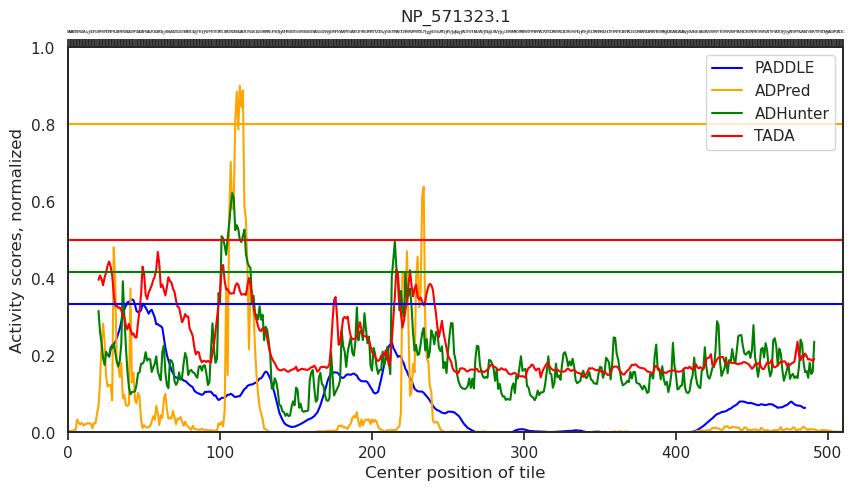

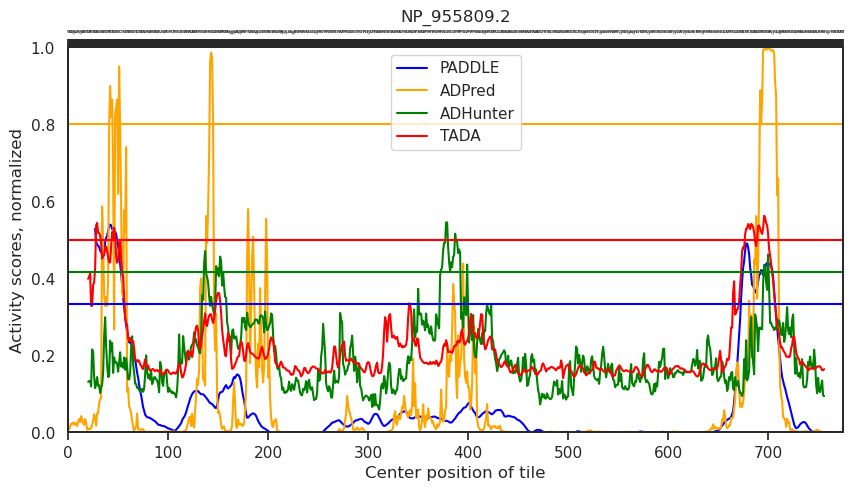

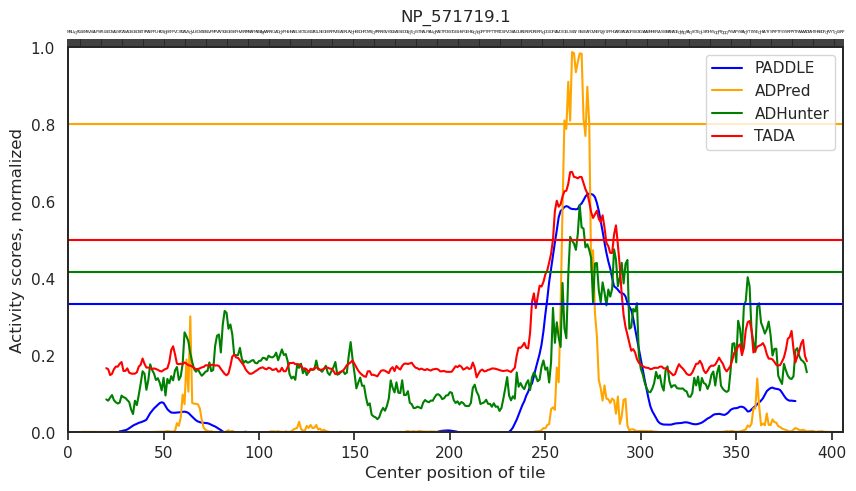

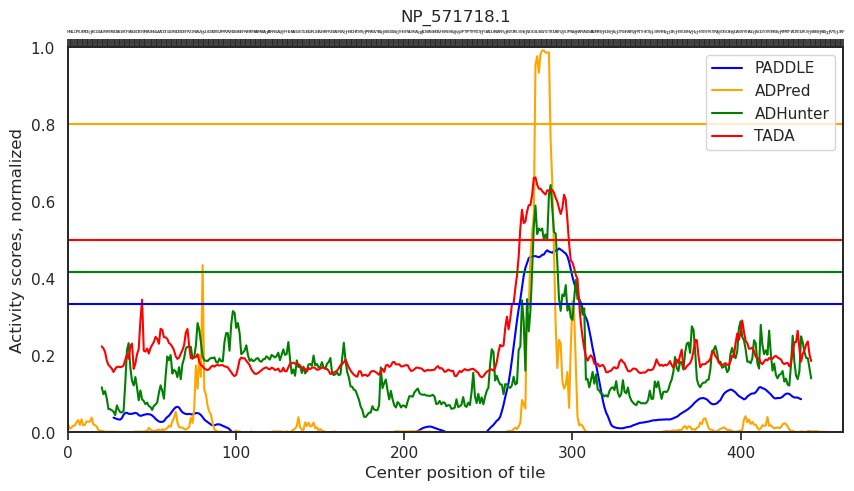

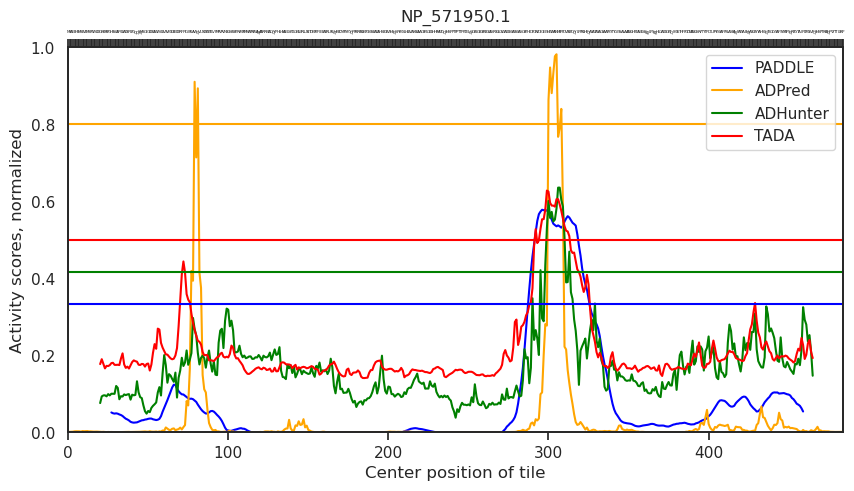

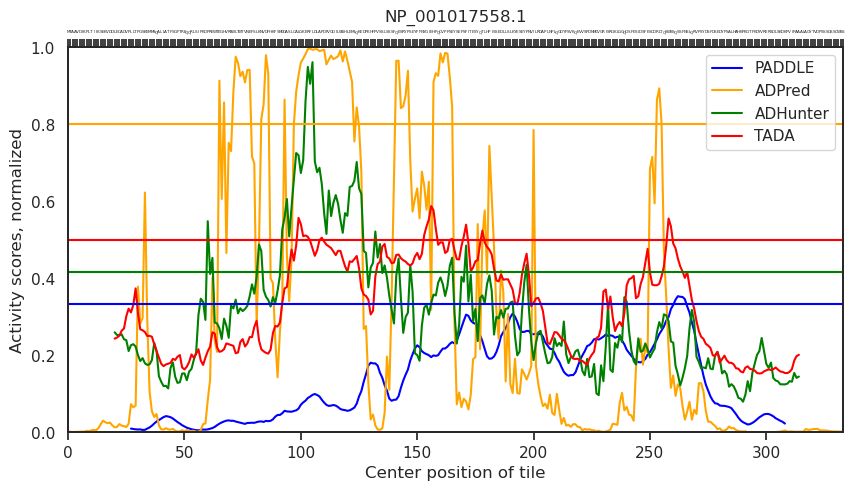

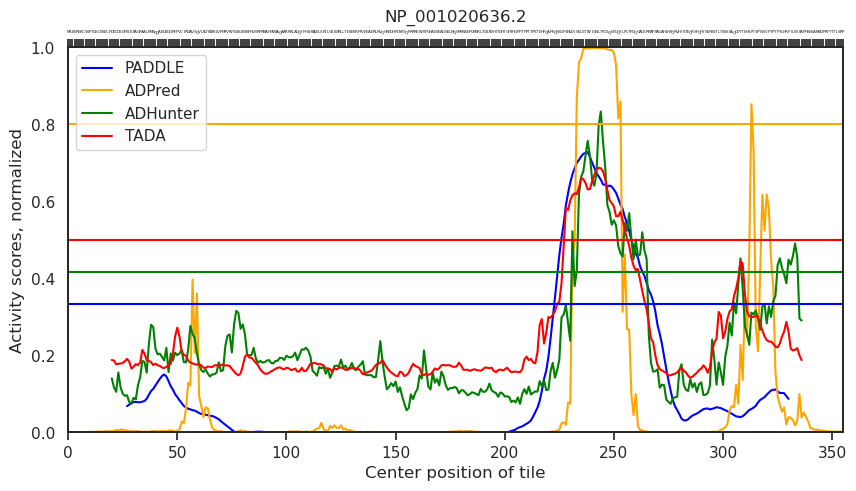

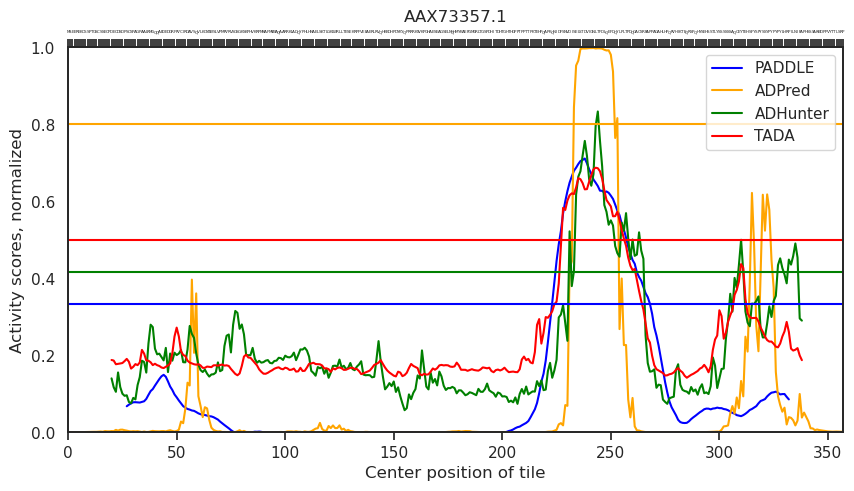

In [ ]:
pdf = matplotlib.backends.backend_pdf.PdfPages(output_dir + "/traces.pdf")

for r in recs:
    sequence = str(r.seq)
    paddle_centers, paddle_preds = paddle_out[sequence]
    adpred_preds = adpred_out[sequence]
    adhunter_centers, adhunter_preds = adhunter_out[sequence]
    tada_centers, tada_preds = tada_out[sequence]

    fig, ax = plt.subplots(figsize=(10,5))

    # Plot activity traces for all three predictors and their activity thresholds
    ax.plot(paddle_centers, normalize_paddle(paddle_preds), c='b', label='PADDLE')
    ax.plot(np.arange(len(sequence)), adpred_preds, c='orange', label='ADPred')
    ax.plot(adhunter_centers, normalize_adhunter(adhunter_preds), c='green', label='ADHunter')
    ax.plot(tada_centers, tada_preds, c='red', label='TADA')
    
    
    ax.plot([0, len(sequence)-1], [.8, .8], '-', c='orange')
    ax.plot([0, len(sequence)-1], [4/12, 4/12], '-', c='b')
    ax.plot([0, len(sequence)-1], [100000/239716, 100000/239716], '-', c='green')
    ax.plot([0, len(sequence)-1], [.5, .5], '-', c='red')

    ax.set_title(r.id)
    ax.legend()
    ax.set_ylim(0, 1)
    ax.margins(x=0)

    ax.set_xlabel('Center position of tile')
    ax.set_ylabel('Activity scores, normalized')

    # Plot protein sequence on a secondary x-axis
    # Comment out this block of code if it looks too messy for you
    ax2 = ax.twiny()
    ax2.set_xticks(np.arange(len(sequence)))
    ax2.set_xticklabels([aa for aa in sequence], fontsize=3)

    pdf.savefig()
    plt.show()
    
pdf.close()

# Save output

In [16]:
# Save predicted values to a csv file
data = []
for r in recs:
    sequence = str(r.seq)
    # paddle_centers, paddle_preds = paddle_out[sequence]
    # adpred_preds = adpred_out[sequence]
    #adhunter_centers, adhunter_preds = adhunter_out[sequence]
    tada_centers, tada_preds = tada_out[sequence]
    
    # data.append([sequence, paddle_centers.tolist(), paddle_preds.tolist(), adpred_preds.tolist(), 
    #              adhunter_centers.tolist(), adhunter_preds.tolist(), tada_centers.tolist(), tada_preds.tolist()])

    data.append([sequence, tada_centers.tolist(), tada_preds.tolist()])
    
out_df = pd.DataFrame(data, columns=['sequence', 'tada_centers', 'tada_preds'])
out_df.to_csv(output_dir + "/tada_preds.csv", encoding='utf-8')

In [22]:
# Save predicted values to a csv file
data = []
for r in recs:
    sequence = str(r.seq)
    # paddle_centers, paddle_preds = paddle_out[sequence]
    # adpred_preds = adpred_out[sequence]
    adhunter_centers, adhunter_preds = adhunter_out[sequence]
    # tada_centers, tada_preds = tada_out[sequence]
    
    # data.append([sequence, paddle_centers.tolist(), paddle_preds.tolist(), adpred_preds.tolist(), 
    #              adhunter_centers.tolist(), adhunter_preds.tolist(), tada_centers.tolist(), tada_preds.tolist()])

    data.append([sequence, adhunter_centers.tolist(), adhunter_preds.tolist()])
    
out_df = pd.DataFrame(data, columns=['sequence', 'adhunter_centers', 'adhunter_preds'])
out_df.to_csv(output_dir + "/adhunter_preds.csv", encoding='utf-8')

In [23]:
pd.read_csv(output_dir + '/adhunter_preds.csv', converters={arr:pd.eval for arr in [ 'adhunter_centers', 'adhunter_preds']})

,Unnamed: 0,sequence,adhunter_centers,adhunter_preds
0,0,MSDWDTNTIIGSRARAGGSGPRANVARSQGQINAARRQGLVVSVDK...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[31849.89453125, 41613.24609375, 49389.296875,..."
1,1,MENTILHIHSFQLPQTEQPYPEAMLFDRDTSDSRTVLTQKPNGLEI...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[36139.390625, 34884.76171875, 48804.37890625,..."
2,2,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[46767.19921875, 34152.359375, 35938.90625, 33..."
3,3,MKLLSSIEQACDICRLKKLKCSKEKPKCAKCLKNNWECRYSPKTKR...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[41379.9296875, 41003.5703125, 40535.5234375, ..."
4,4,MDYNKRSSVSTVPNAAPIRVGFVGLNAAKGWAIKTHYPAILQLSSQ...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[44679.0390625, 52586.07421875, 46660.26953125..."
...,...,...,...,...
242,242,MPSRTPTDIWRCQRLILAARKGETTCQALHEQSIEISSSLKWFEEI...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[34101.15625, 34034.15625, 35412.7734375, 4152..."
243,243,MQFTILNEPSLDSQRREGDLASENYVFGDIRKEGVRILEDSLRSER...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[42407.765625, 33381.203125, 34185.265625, 326..."
244,244,MNVQEIHNIREACITILSGTKHNSVLFEPCDKFDEVINSLDIDPDS...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[58547.73046875, 50564.12890625, 63022.4921875..."
245,245,MCDNDMADIQSKLSSFCEEIRALALKEGYNLEGDKSPSSKPYFMSW...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[25121.4609375, 22103.61328125, 26708.01171875..."


# STOP

In [25]:
output_dir

'/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/consensus_AD_predictor/output/yeast_TFs_preds/yeast_TF'